# Import

In [1]:
import sys
from pathlib import Path

##os.getcwd()
if "../scripts/" not in sys.path:  # to prevent multyadding  
    sys.path.append("../scripts/") 
# types

from pydantic import BaseModel
from typing import Callable

# work with data
import numpy as np
import pandas as pd
import tensorflow as tf

# visualization
import cv2

from get_data import data_dir, read_configuration
from data_handle import predict_img_tflite, predict_img_tf
from helpers import print_imgs


In [2]:
configuration = read_configuration(data_dir / "config.yaml")

# Load data

In [3]:
INPUT, PATHS, EMOTIONS = configuration['input'], configuration['paths'], configuration['emotions']

# model_65_file = './checkpoints/model_MobNetLike/1v1-noregdepwisw_dropout0.2/cp_model-E0181--val_acc0.6573--val_loss1.1014.keras'

In [4]:
model = tf.keras.models.load_model(PATHS['model_path'])

In [5]:
PATHS['tflite_model_path']

WindowsPath('../results/quantized_model.tflite')

In [6]:
interpreter_lite_model = tf.lite.Interpreter(model_path=PATHS['tflite_model_path'].as_posix())

c:\Users\alena\AI\emotions-detector\.venv\Lib\site-packages\tensorflow\lite\python\interpreter.py:457: UserWarning:     Warning: tf.lite.Interpreter is deprecated and is scheduled for deletion in
    TF 2.20. Please use the LiteRT interpreter from the ai_edge_litert package.
    See the [migration guide](https://ai.google.dev/edge/litert/migration)
    for details.
    
  warnings.warn(_INTERPRETER_DELETION_WARNING)


In [7]:
img_shape = model.input_shape[1:3]
img_dtype = model.input_dtype
f'{img_shape=}, {img_dtype=}'

"img_shape=(48, 48), img_dtype='float32'"

# Functions

## Predict emotion

In [8]:
#load the pre-trained Haar Cascade classifier
face_classifier = cv2.CascadeClassifier(
    cv2.data.haarcascades + "haarcascade_frontalface_default.xml"
)

In [9]:
def get_face(vid):
    gray_image = cv2.cvtColor(vid, cv2.COLOR_BGR2GRAY)
    faces = face_classifier.detectMultiScale(gray_image, 1.1, 7, minSize=(40, 40))
    if len(faces) == 0:
        return None, (0,0,0,0)
    
    x, y, w, h = faces[0]
    return gray_image[y:y + h, x:x + w], (x, y, w, h)

In [10]:
# use this class to keep predicted emotions to compare them to the emotion predicted from previose frame
class PredictedEmotion(BaseModel):
    emotion: str
    probabylity: float
    index: int

In [11]:
def predict_emotion(predict_img_fn:Callable, img: np.ndarray, previous_emotion: PredictedEmotion|None=None, confidence_threshold:float=0.65, diff_thershold:float=0.1) -> PredictedEmotion:
    """
    predicts the emotion of an image
    :param img: NumPy array (or array-like) an input image to predict emotion  
    :return: string, corresponding one of the emotion: ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral'] 
    """
    
    probabylities = predict_img_fn(img)
    idx = probabylities.argmax()
    predicted_emotion = PredictedEmotion(emotion=EMOTIONS[idx], probabylity=probabylities[idx], index=idx) 
    
    if previous_emotion is not None:
        if previous_emotion.index == idx:
            return previous_emotion
        elif predicted_emotion.probabylity > confidence_threshold:
            return predicted_emotion
        elif abs(previous_emotion.probabylity - predicted_emotion.probabylity)/predicted_emotion.probabylity > diff_thershold:
            return predicted_emotion
        else:
            return previous_emotion

    return predicted_emotion

In [12]:
# use predict functions with current parameters - model and interpreter, so that they depend on image only
predict_img_tf_local = lambda img: predict_img_tf(img, model=model, img_shape=img_shape, flt_type=np.float32)
predict_img_tflite_local = lambda img: predict_img_tflite(img, interpreter=interpreter_lite_model,
                                                          input_index=interpreter_lite_model.get_input_details()[0]['index'], 
                                                          output_index=interpreter_lite_model.get_output_details()[0]['index'],
                                                          img_shape=img_shape, flt_type=np.float32)

## Capture and predict
Capture images from the camera and predict emotions in this images.

In [13]:
def capture_and_predict_emotions(video_capture:cv2.VideoCapture, 
                                 num_faces_to_process:int=25, 
                                 max_error_faces_recognition:int=120)->tuple[np.ndarray, np.ndarray[str], int]:
    """
    Capture faces from camera, predict emotions on them using tf and tflite models and keep the pictures along with predicted emotions. 
    """
    faces = np.zeros(num_faces_to_process,dtype=np.object_)
    predicted_emotions = np.ndarray(num_faces_to_process, dtype=np.object_)
    none_recognized=0
    face_counter = 0
    frequency = int(video_capture.get(cv2.CAP_PROP_FPS))
    frame_count = frequency
    while face_counter<num_faces_to_process:
        result, video_frame = video_capture.read()  # read frames from the video
        if result is False:
            break  # terminate the loop if the frame is not read successfully

        if frame_count==frequency:
            frame_count=0
            face, _ = get_face(video_frame)  
            if face is not None:
                faces[face_counter] = face
                predicted_emotions[face_counter] = predict_emotion(predict_img_tf_local, face).emotion
                predicted_emotions[face_counter] +='/' + predict_emotion(predict_img_tflite_local, face).emotion
                face_counter += 1
            else:
                none_recognized += 1
                if none_recognized>max_error_faces_recognition:
                    break
            
        frame_count += 1
    # gray = cv2.cvtColor(video_frame, cv2.COLOR_BGR2GRAY)
    # cv2.imshow('frame', gray)
    # if cv2.waitKey(1) & 0xFF == ord("q"):
    #     break
    #time.sleep(0.5)
    video_capture.release()
    cv2.destroyAllWindows()
    return faces, predicted_emotions, none_recognized


In [14]:
def predict_emotions_video(predict_img_fn:Callable, video_capture:cv2.VideoCapture, max_error_faces_recognition:int=120)->int:
    """
    Predict emotions in real time video.
    """
    none_recognized=0
    frequency = int(video_capture.get(cv2.CAP_PROP_FPS))//2
    frame_count = frequency
    font = cv2.FONT_HERSHEY_SIMPLEX 
    predicted_emotion = PredictedEmotion(emotion='Neutral', probabylity=1.0, index=6)
    while True:
        result, video_frame = video_capture.read()  # read frames from the video
        if result is False:
            break  # terminate the loop if the frame is not read successfully
  
        face, (x, y, w, h) = get_face(video_frame)  
        if face is not None:
            cv2.rectangle(video_frame, (x, y), (x+w, y+h), (12, 122, 12), 2)
            
            # predict the emotion of the face for every 0.5 seconds
            if frame_count==frequency:
                frame_count=0
                predicted_emotion = predict_emotion(predict_img_fn, face, predicted_emotion)
            
            cv2.putText(video_frame,  
                        predicted_emotion.emotion,  
                        (x, y-10),  
                        font, 1,  
                        (12, 122, 12),  
                        2,  
                        cv2.LINE_4) 
            frame_count += 1
        else:
            none_recognized += 1
            if none_recognized>max_error_faces_recognition:
                break
            

  
        # Display the resulting frame 
        cv2.imshow('video', video_frame) 
    
        # creating 'q' as the quit  
        # button for the video 
        if cv2.waitKey(1) & 0xFF == ord('q'): 
            break
    # gray = cv2.cvtColor(video_frame, cv2.COLOR_BGR2GRAY)
    # cv2.imshow('frame', gray)
    #time.sleep(0.5)
    video_capture.release()
    cv2.destroyAllWindows()
    return none_recognized


# Capture and predict

### Images

In [29]:
video_capture = cv2.VideoCapture(0)

In [30]:
n_faces = 25
faces, predicted_emotions, not_recognized = capture_and_predict_emotions(video_capture, n_faces)
print(f'{not_recognized=}')

not_recognized=0


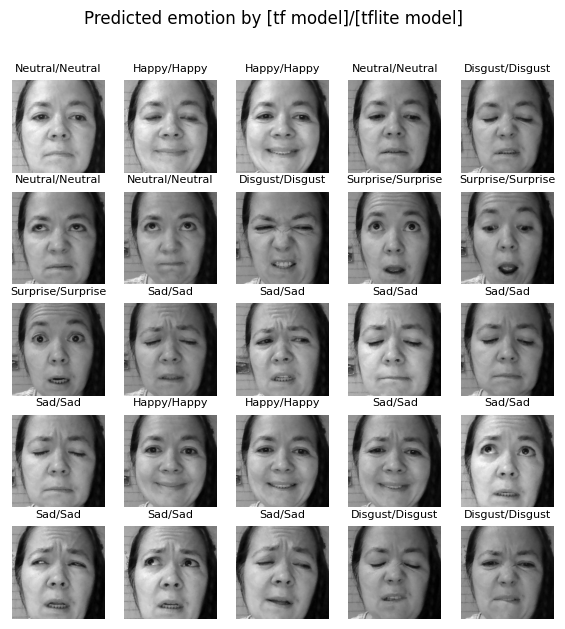

Predicted emotions saved to C:\Users\alena\AI\emotions-detector\results\predicted_emotions.png


In [32]:
fig = print_imgs(faces, predicted_emotions, title='Predicted emotion by [tf model]/[tflite model]')
file_path = PATHS['res_dir'] / 'predicted_emotions.png'
fig.savefig(file_path)
print(f'Predicted emotions saved to {file_path.resolve()}') 

### Video

In [18]:
video_capture = cv2.VideoCapture(0)

In [19]:
print("Press 'q' to quit the video stream.")
not_recognized = predict_emotions_video(predict_img_tf_local, video_capture, max_error_faces_recognition=np.inf)

Press 'q' to quit the video stream.


In [20]:
video_capture = cv2.VideoCapture(0)

In [21]:
# try quantizated model
not_recognized = predict_emotions_video(predict_img_tflite_local, video_capture, max_error_faces_recognition=np.inf)